# Exercise 07 CNN & Transfer Learning - Assignment

<span style="color:red">**The submission deadline of this assignment is 15/04/2024 23:59.**</span>

<span style="color:red">**Do not submit the saved `.pth` file of the trained CNN, because the file size is too big.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classifier with pre-trained Squeeze Net using transfer learning.

The problem to be solved is to classify grayscale images into one of the 10 pre-defined classes:

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

|Label|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|-|
|Class|T-shit/top|Trouser|Pullover|Dress|Coat|Sandal|Shirt|Sneaker|Bag|Ankle boot|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Load pre-trained model and re-build the classifier
- Train the re-built classifier
- Test and evaluation
- (Optional) Fine-tuning entire CNN

### Import libraries

In [2]:
# [TBC] complete your code here with proper comments
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torch
import torchvision.models as models

import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report


## Task 1. Build the data pipeline

You are required to use the PyTorch built-in Fashion MNIST dataset, consists of 70,000 $28\times28$ grayscale images in 10 classes, with 7,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) and the [original source](https://github.com/zalandoresearch/fashion-mnist).

To use the Fashion MNIST dataset and the pre-trained Squeeze Net, apart from the pre-processing transformations illustrated in the Instruction notebook, you also need to convert the grayscale image to the RGB image. To do this, you can add an additional transformation `transforms.Grayscale(num_output_channels=3)` to the sequence of transformations you defined.

<span style="color:red">**[TBC]**</span> You need to:
- Define a sequence of transformations to pre-process the images
- Use `torchvision.datasets.FashionMNIST()` to load the dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# Build the Data Pipeline

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load the Dataset
# Loading the training dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Loading the testing dataset
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11717134.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206417.00it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3937816.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15680665.93it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
# Split the Dataset
# Splitting the training dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])


In [6]:
# Create DataLoader Instances

batch_size = 64  # Adjust based on your system's specifications

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Task 2. Load Pre-trained model and Re-build the classifier

<span style="color:red">**[TBC]**</span> You need to:
- Load the pre-trained Squeeze Net
- Replace the `classifier` part
- Freeze the `features` part
- Set up GPU acceleration if it's possible

In [7]:
# Load pre-trained SqueezeNet
model = models.squeezenet1_1(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 31.6MB/s]


In [8]:
# Replace the Classifier

# Number of classes in Fashion MNIST
num_classes = 10

# Replace the classifier - assume the model has classifier attribute which SqueezeNet has not
# It's a bit tricky because SqueezeNet uses a different classifier concept
model.classifier[1] = torch.nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model.num_classes = num_classes

In [9]:
# Freeze the Features Part

for param in model.features.parameters():
    param.requires_grad = False

In [10]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

# Move the model to the chosen device
model = model.to(device)

Using cpu device.


## Task 3. Train the re-built classifier

<span style="color:red">**[TBC]**</span> You need to:

- Define a `train()` function
    - Embed automatic model saving in the training process
    - <span style="color:red">**Do not submit the saved file as it will be too big.**</span>
- Specify the training hyper-parameters
- Train the network
- Reload the best model after training
- Plot the loss history of the training probess

In [11]:
# Define the train() Function
def train(model, device, train_loader, val_loader, epochs, optimizer, criterion, save_path):
    min_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        val_loss = evaluate(model, device, val_loader, criterion)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the model if the validation loss decreased
        if val_loss < min_val_loss:
            print(f"Validation loss decreased ({min_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
            torch.save(model.state_dict(), save_path)
            min_val_loss = val_loss

    return train_losses, val_losses

def evaluate(model, device, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

    return total_loss / len(dataloader.dataset)

In [13]:
# Specify the Training Hyper-parameters

epochs = 1 # Limited to computing resources
learning_rate = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
save_path = 'best_CNN.pth'


In [14]:
# Train the Network

train_losses, val_losses = train(model, device, train_loader, val_loader, epochs, optimizer, criterion, save_path)


Epoch 1/1: 100%|██████████| 750/750 [41:47<00:00,  3.34s/batch]


Epoch 1, Train Loss: 0.4870, Val Loss: 0.3631
Validation loss decreased (inf --> 0.3631). Saving model...


In [15]:
# Reload the Best Model

model.load_state_dict(torch.load(save_path))
model = model.to(device)


## Step 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [16]:

# Define the test() Function


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    results = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            prob = F.softmax(output, dim=1)
            pred = prob.argmax(dim=1, keepdim=True)  # get the index of the max probability
            results.extend([(p.item(), t.item(), pr.item()) for p, t, pr in zip(pred, target, prob.max(dim=1).values)])

    test_loss /= len(test_loader.dataset)
    return test_loss, results


In [17]:
# Test for one class
criterion = nn.CrossEntropyLoss()
test_loss, results = test(model, device, test_loader, criterion)
print(f'Test set: Average loss: {test_loss:.4f}')


Test set: Average loss: 0.0061


In [18]:
# Adjust the test() Function for Multiclass
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    results = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            prob = F.softmax(output, dim=1)
            pred = prob.argmax(dim=1, keepdim=False)  # get the index of the max log-probability
            results.extend([(pred[i].item(), target[i].item()) for i in range(target.size(0))])

    test_loss /= len(test_loader.dataset)
    return test_loss, results


In [19]:
# Collect Predictions and True Labels
test_loss, results = test(model, device, test_loader, criterion)
y_true, y_pred = zip(*results)
print(f'Test set: Average loss: {test_loss:.4f}')


Test set: Average loss: 0.0061


In [20]:

print(classification_report(y_true, y_pred, target_names=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]))



              precision    recall  f1-score   support

 T-shirt/top       0.91      0.71      0.80      1294
     Trouser       0.96      0.99      0.98       971
    Pullover       0.80      0.86      0.83       930
       Dress       0.81      0.87      0.84       937
        Coat       0.80      0.80      0.80      1005
      Sandal       0.92      0.98      0.95       939
       Shirt       0.59      0.66      0.62       901
     Sneaker       0.99      0.88      0.93      1122
         Bag       0.95      0.98      0.97       964
  Ankle boot       0.91      0.98      0.94       937

    accuracy                           0.86     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.87      0.86      0.86     10000



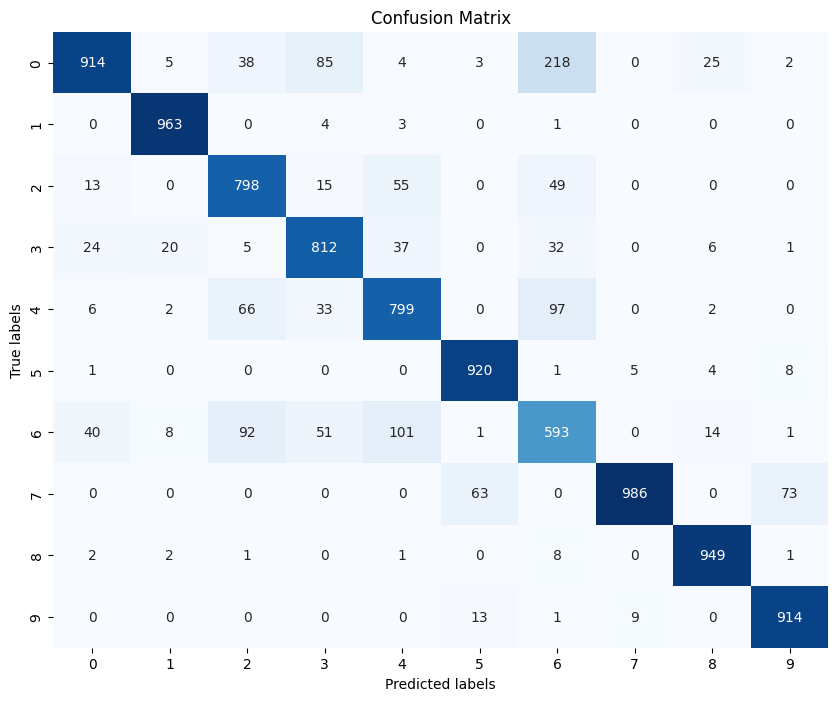

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Optional Task. Fine-tuning entire CNN

This task is not mandatory. You need to:
- Unfreeze the `feature extractor`
- Fine-tune the entire netowrk (both the `feature extractor` and the `classifier`) with a relative small learning rate
- Reload the best model after fine-tuning
- Test and evaluation

In [ ]:
# [TBC] complete your code here with proper comments

# Unfreeze the Entire Network
for param in model.parameters():
    param.requires_grad = True

# Define a smaller learning rate for fine-tuning
fine_tune_learning_rate = 0.0001  # Adjust as needed

# Define a new optimizer for fine-tuning the entire network
fine_tune_optimizer = optim.Adam(model.parameters(), lr=fine_tune_learning_rate)

# Train the Entire Network for fine-tuning
fine_tune_epochs = 1  # Adjust as needed
fine_tune_train_losses, fine_tune_val_losses = train(model, device, train_loader, val_loader, fine_tune_epochs, fine_tune_optimizer, criterion, save_path)

# Reload the Best Fine-tuned Model
model.load_state_dict(torch.load(save_path))
model = model.to(device)

# Test the Fine-tuned Model
fine_tune_test_loss, fine_tune_results = test(model, device, test_loader, criterion)
fine_tune_y_true, fine_tune_y_pred = zip(*fine_tune_results)
print(f'Fine-tuned Test set: Average loss: {fine_tune_test_loss:.4f}')



Epoch 1/1:  33%|███▎      | 248/750 [24:18<48:35,  5.81s/batch]